In [8]:
import urllib
from PIL import Image
import torchvision.transforms as T
import itertools
import math 
import torch.nn.functional as F
import numpy as np 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

In [6]:
def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

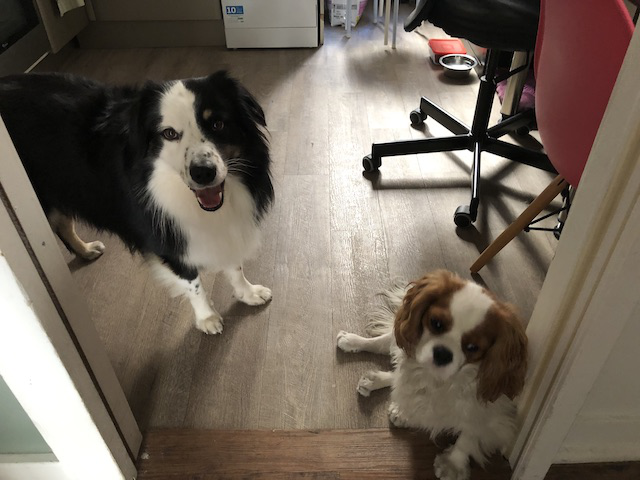

In [7]:
EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"

image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(image)

In [9]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').cuda()
dinov2_vitl14.eval()

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/st34/.cache/torch/hub/main.zip
/home/st34/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/st34/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/st34/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /home/st34/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:21<00:00, 57.9MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1):

In [10]:
class CenterPadding(torch.nn.Module):
    def __init__(self, multiple = 14):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


transform = T.Compose([
    # T.CenterCrop(224),
    T.ToTensor(),
    lambda x: x.unsqueeze(0),
    CenterPadding(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


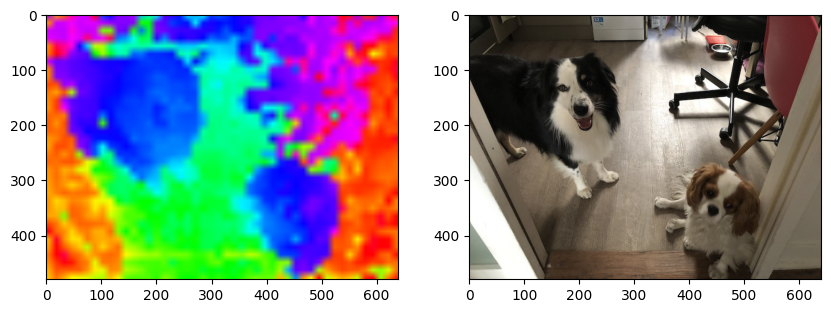

In [11]:
with torch.no_grad():
    # features = dinov2_vitl14(transform(image).cuda())
    features_1 = dinov2_vitl14.forward_features(transform(image).cuda())#["x_norm_patchtokens"]

pca = PCA(n_components=3) 
feature_np = features_1["x_norm_patchtokens"].cpu().numpy()[0]
pca.fit(feature_np)

pca_features = pca.transform(feature_np) 

# pca_features_vis = F.normalize(torch.from_numpy(pca_features.reshape(35, 46, 3)), dim = -1).numpy() * 0.5 + 0.5
pca_features_np = pca_features.reshape(35, 46, 3)
pca_feature_vis = (pca_features_np - pca_features_np.min(axis = -1)[..., None]) / (pca_features_np.max(axis = -1)[..., None] - pca_features_np.min(axis = -1)[..., None])

pca_feature_vis = T.CenterCrop((480, 640)) (F.interpolate(torch.from_numpy(pca_feature_vis).permute(2, 0, 1)[None], size = (35 * 14, 46 * 14), mode = "bilinear", align_corners = False))[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pca_feature_vis)
plt.subplot(1, 2, 2)
plt.imshow(T.ToTensor()(image).permute(1,2,0))
plt.show()

Testing last 4 layers concat

In [12]:
layers = [20, 21, 22, 23]

with torch.no_grad():
    # features = dinov2_vitl14(transform(image).cuda())
    features = dinov2_vitl14.get_intermediate_layers(transform(image).cuda(), n = layers)#["x_norm_patchtokens"]

In [13]:
features = torch.stack(features, dim = -1)
L, C = features.shape[1: 3]
features = features.view(1, L, C * len(layers))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


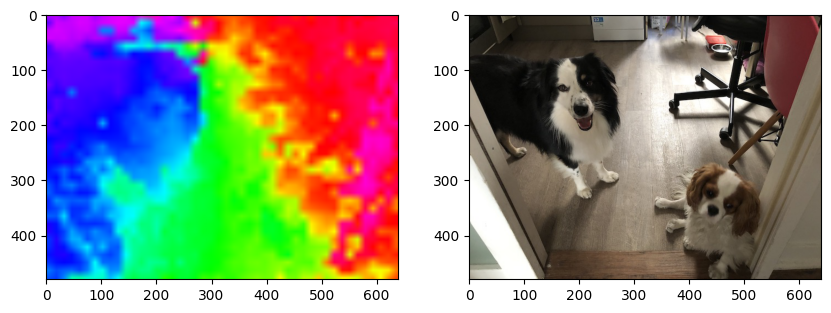

In [14]:
pca = PCA(n_components=3) 
feature_np = features.cpu().numpy()[0]
pca.fit(feature_np)

pca_features = pca.transform(feature_np) 

# pca_features_vis = F.normalize(torch.from_numpy(pca_features.reshape(35, 46, 3)), dim = -1).numpy() * 0.5 + 0.5
pca_features_np = pca_features.reshape(35, 46, 3)
pca_feature_vis = (pca_features_np - pca_features_np.min(axis = -1)[..., None]) / (pca_features_np.max(axis = -1)[..., None] - pca_features_np.min(axis = -1)[..., None])

pca_feature_vis = T.CenterCrop((480, 640)) (F.interpolate(torch.from_numpy(pca_feature_vis).permute(2, 0, 1)[None], size = (35 * 14, 46 * 14), mode = "bilinear", align_corners = False))[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pca_feature_vis)
plt.subplot(1, 2, 2)
plt.imshow(T.ToTensor()(image).permute(1,2,0))
plt.show()

In [15]:
pca_feature_vis.min(), pca_feature_vis.max()

(0.0, 1.0000001)

Final end to end code

In [16]:
import os
import pickle
import urllib
from PIL import Image
import torchvision.transforms as T
import itertools
import math 
import torch.nn.functional as F
import numpy as np 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch


In [18]:

def load_images_from_folder(folder_path):
    """Load all images from a specified folder and return their filenames."""
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    images = [Image.open(os.path.join(folder_path, img_file)).convert("RGB") for img_file in image_files]
    return images, image_files


def extract_features(image, model, layers=[20, 21, 22, 23]):
    """Extract features from an image using the DINO v2 model."""
    transform = T.Compose([
        T.ToTensor(),
        lambda x: x.unsqueeze(0),
        CenterPadding(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    
    with torch.no_grad():
        features_out = model.get_intermediate_layers(transform(image).cuda(), n=layers)
    features = torch.stack(features_out, dim=-1)
    L, C = features.shape[1: 3]
    features = features.view(1, L, C * len(layers))
    
    return features

def upsample_features(features, original_image_size):
    """Upsample the extracted features to match the original image size."""
    padding_multiple = 14
    padded_height = math.ceil(original_image_size[0] / padding_multiple) * padding_multiple
    padded_width = math.ceil(original_image_size[1] / padding_multiple) * padding_multiple
    upsampled_features = F.interpolate(features, size=(padded_height, padded_width), mode="bilinear", align_corners=False)
    height_pad = (padded_height - original_image_size[0]) // 2
    width_pad = (padded_width - original_image_size[1]) // 2
    upsampled_features = upsampled_features[:, :, height_pad:height_pad+original_image_size[0], width_pad:width_pad+original_image_size[1]]
    
    return upsampled_features


def save_features_as_pkl(features, filename, folder="Dino Features 23_4"):
    """Save the features as a .pkl file."""
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Construct the full path for the .pkl file
    base_name = os.path.splitext(filename)[0]  # Remove the file extension
    pkl_filename = f"{base_name}_dino_23_4_features.pkl"
    pkl_path = os.path.join(folder, pkl_filename)
    
    with open(pkl_path, 'wb') as f:
        pickle.dump(features.cpu().numpy(), f)


def main(folder_path, model):
    """Main function to process all images in a folder, extract and save their upsampled features."""
    images, filenames = load_images_from_folder(folder_path)
    for img, fname in zip(images, filenames):
        features = extract_features(img, model)
        upsampled = upsample_features(features, (img.height, img.width))
        save_features_as_pkl(upsampled, fname)


In [20]:

model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').cuda().eval()
main("/path/to/folder", model)